In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy
import itertools
import tqdm
from datetime import datetime
import netCDF4 as nc 
from scipy.stats import linregress
from scipy.interpolate import griddata
import warnings
import pickle
warnings.filterwarnings("ignore")


In [11]:
save_fig = 0

## Fonctions for the analysis

In [12]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion

def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    slope, intercept = np.polyfit(validation_data, calculated_data, 1)

    return md, rmse, r2, slope, intercept


In [13]:
def filter_data(oib_file, oib_snow, snow_file, snow, lon, lat, is2_file, cs_file, Hi_data, Hs_data):
    ''' filters out the data that is available in both OIB and inversion files'''
    #loading OIB data
    #OIB = nc.Dataset('/home/erb/masterproject/MSCI_project/OIB/25km_ease_binned_data/20190415.nc')
    OIB  = nc.Dataset(oib_file)
    SD   = OIB.variables['Snow Depth'][:,:]
    long = OIB.variables['Longitude'][:,:]
    lati = OIB.variables['Latitude'][:,:]

    # loading inversion and freeboard data
    is2 = np.load(is2_file)
    cs  = np.load(cs_file)
    inverse_snow = np.load(snow_file)
    inverse_snow = mask_observations(is2, inverse_snow) # mask the observations to actual Altika tracks

    # forward linear regression
    DENSITY_WATER = 997.0
    DENSITY_ICE = 917.0
    DENSITY_SNOW = 300.0
    SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW = 1.28

    A = (DENSITY_WATER - DENSITY_ICE) / DENSITY_WATER
    B = 1 - SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW -DENSITY_SNOW/DENSITY_WATER
    D = 1 - DENSITY_SNOW/DENSITY_WATER

    Hi = (D*cs - B*is2)/ A*(D-B)
    Hs = (cs - is2) / (B -D)


    for i in range(360):
        for j in range(360):
            if not (SD.mask[i][j]) and not np.isnan(inverse_snow[i][j]):
                    #print(SD.data[i][j])
                oib_snow.append(SD.data[i][j])
                snow.append(inverse_snow[i][j])
                lon.append(long.data[i][j])
                lat.append(lati.data[i][j])
                Hi_data.append(Hi[i][j])
                Hs_data.append(Hs[i][j])

    OIB.close() 

In [14]:
import os

def extract_dates(folder_path):
    date = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.npy_snow') and not filename.endswith('.npy_ice_stddev'):
            info = filename.split('_')[4].split('.')[0] #split by '_' and remove .npy
            date.append(info)
    date.sort()
    return date

def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{year-1}-{year}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        #filename = f"tesselationVoronoi_initcell10_iteration100000_date{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_IS2_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        filename = f"FB_interp_{year}_25km_{date}{type}"
        #filename = f"tesselationVoronoi_initcell10_iteration100000_date{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_snow_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        #filename = f"FB_interp_{year}_25km_{date}{type}"
        filename = f"tesselationDelaunay_initcell1000_iteration700000_date{date}_inputtypePeerIndices_priorOldPrior_snow{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_OIB(folder_path, dates):
    files = []
    for date in dates:
        filename = f'{date}.nc'
        file_path = os.path.join(folder_path, filename)

        #if os.path.exists(file_path):
        files.append(file_path)

    return files


In [15]:
import os


def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{2019}-{2020}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

## Validation for snow

In [16]:
# MOSAIC Validation data (Winter 2019 - 2020)

date = ['20191115', '20191215', '20200115', '20200215', '20200315', '20200415' ]

snow_files = extract_snow_files('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/', date, '.npy')
MOSAIC_files = extract_OIB('/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_MOSAIC', date)
is2_files = extract_IS2_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/', date,'.npy')
cs_files = extract_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/', date, '.npy')

In [17]:
# Initialize arrays to store filtered data
MOSAIC_snow = []
lon_data = []
lat_data = []
snow_data = []
Hi_data = []
Hs_data = []

for i in range(len(date)):
    filter_data(MOSAIC_files[i], MOSAIC_snow, snow_files[i], snow_data, lon_data, lat_data, is2_files[i], cs_files[i], Hi_data, Hs_data)

In [18]:
plt.figure()
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
plt.title('MOSAIC Tracks Winther 2019-2020')
m.scatter(lon_data, lat_data, latlon=True, alpha=1, s=0.5, c=MOSAIC_snow, cmap="coolwarm", vmin=0, vmax=6)
plt.show()

year = '2019-2020'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/MOSAiC_tracks' + year + '.png')


NameError: name 'Basemap' is not defined

<Figure size 640x480 with 0 Axes>

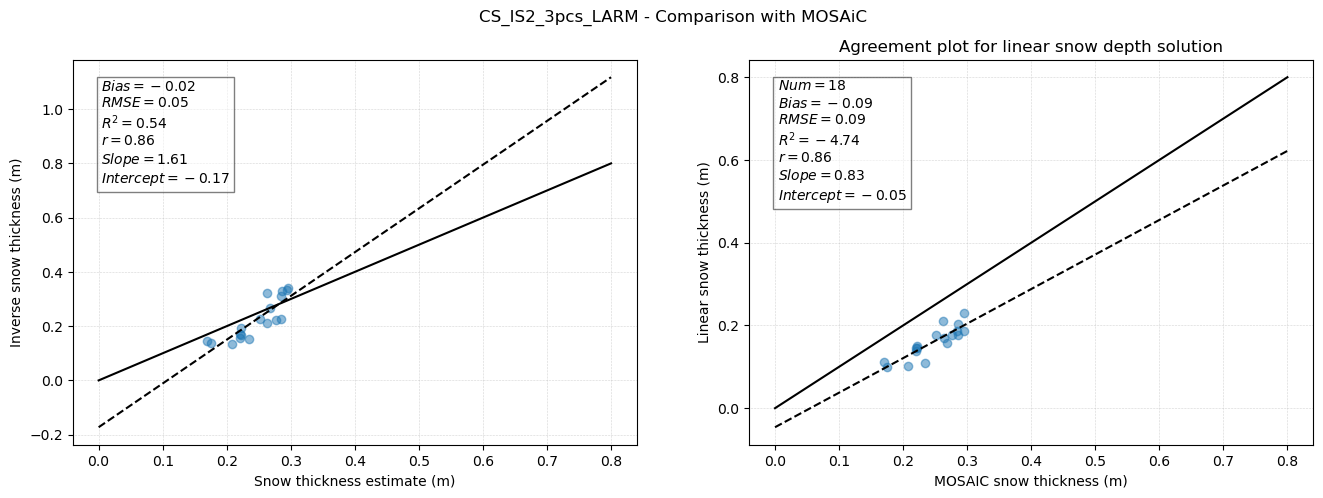

In [ ]:
fig = plt.figure(figsize=(16, 5))


plt.suptitle('CS_IS2_3pcs_LARM - Comparison with MOSAiC')
ax = fig.add_subplot(121)

plt.scatter(MOSAIC_snow, snow_data, alpha = 0.5)
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('Snow thickness estimate (m)')
plt.ylabel('Inverse snow thickness (m)')
#ax.set_title("Agreement plot for inverse snow model")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_data, MOSAIC_snow)
r_snow = pearson(MOSAIC_snow, snow_data)

textstr = '\n'.join((
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')


ax = fig.add_subplot(122)
data = np.array(Hs_data)
md, rmse, r2, slope, intercept = analyse(data, MOSAIC_snow)
r_snow_linear = pearson(MOSAIC_snow, Hs_data)


plt.scatter(MOSAIC_snow, Hs_data, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.xlabel('MOSAIC snow thickness (m)')
plt.ylabel('Linear snow thickness (m)')

textstr = '\n'.join((
    rf'$Num = {len(Hs_data)}$',
    rf'$Bias={md:.2f}$',
    rf'$RMSE={rmse:.2f}$',
    rf'$R^2={r2:.2f}$',
    rf'$r = {r_snow_linear:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)
# Plot linear regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')
ax.set_title("Agreement plot for linear snow depth solution")


if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/validation_MOSAiC' + year + '.png')


In [ ]:
import os

def extract_snow_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        #filename = f"FB_interp_{year}_25km_{date}{type}"
        filename = f"tesselationDelaunay_initcell1000_iteration700000_date{date}_proposal0.1_window+-2j_prioruniform-0.5-0.8_error0.01_alphais2_snow{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

def extract_files(folder_path, dates, type):
    matching_files = []
    for date in dates:
        year = int(date[:4])  # Extract the year from the date
        initial_year = f"{2018}-{2019}"
        filename = f"FB_interp_{initial_year}_25km_{date}{type}"
        file_path = os.path.join(folder_path, filename)
        #if os.path.exists(file_path):
        matching_files.append(file_path)
    return matching_files

In [ ]:
# IceBird Validation data 

date = ['20190415']

snow_files = extract_snow_files('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input', date, '.npy')
IB_files = extract_OIB('/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_IB', date)
is2_files = extract_IS2_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/', date,'.npy')
cs_files = extract_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/', date, '.npy')

In [ ]:
# Initialize arrays to store filtered data
IB_snow = []
lon_data = []
lat_data = []
snow_data = []
Hi_data = []
Hs_data = []

for i in range(len(date)):
    filter_data(IB_files[i], IB_snow, snow_files[i], snow_data, lon_data, lat_data, is2_files[i], cs_files[i], Hi_data, Hs_data)

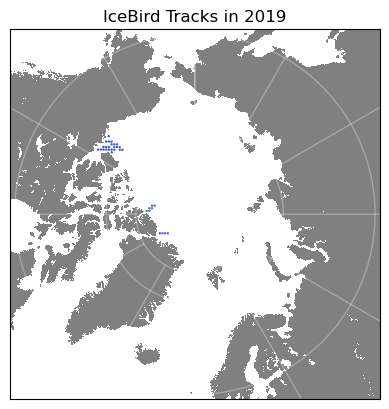

In [ ]:
plt.figure()
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
plt.title('IceBird Tracks in 2019')
m.scatter(lon_data, lat_data, latlon=True, alpha=1, s=0.5, c=IB_snow, cmap="coolwarm", vmin=0, vmax=6)
plt.show()

year = '04-2019'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/IceBird_tracks' + year + '.png')



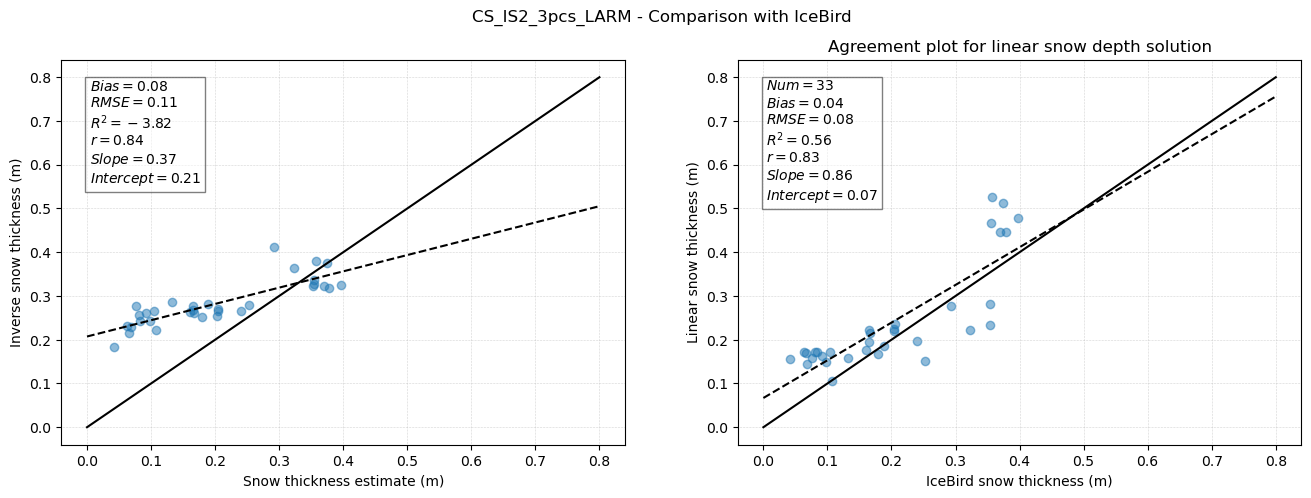

In [ ]:
fig = plt.figure(figsize = (16,5))
plt.suptitle('CS_IS2_3pcs_LARM - Comparison with IceBird')

ax = fig.add_subplot(121)
plt.scatter(IB_snow, snow_data, alpha = 0.5)
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('Snow thickness estimate (m)')
plt.ylabel('Inverse snow thickness (m)')
#ax.set_title("Agreement plot for inverse snow model")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_data, IB_snow)
r_snow = pearson(IB_snow, snow_data)

textstr = '\n'.join((
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')


ax = fig.add_subplot(122)
data = np.array(Hs_data)
md, rmse, r2, slope, intercept = analyse(data, IB_snow)
r_snow_linear = pearson(IB_snow, Hs_data)

plt.scatter(IB_snow, Hs_data, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.xlabel('IceBird snow thickness (m)')
plt.ylabel('Linear snow thickness (m)')

textstr = '\n'.join((
    rf'$Num = {len(Hs_data)}$',
    rf'$Bias={md:.2f}$',
    rf'$RMSE={rmse:.2f}$',
    rf'$R^2={r2:.2f}$',
    rf'$r = {r_snow_linear:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)
# Plot linear regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')
ax.set_title("Agreement plot for linear snow depth solution")


if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/validation_IceBird' + year + '.png')



In [ ]:
# OIB Validation data 

date = ['20190415']

snow_files = extract_snow_files('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/', date, '.npy')
OIB_files = extract_OIB('/home/erb/masterproject/MSCI_project/validation_data/UIT_OIB', date)
is2_files = extract_IS2_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/', date,'.npy')
cs_files = extract_files('/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/', date, '.npy')

In [ ]:
# Initialize arrays to store filtered data
OIB_snow = []
lon_data = []
lat_data = []
snow_data = []
Hi_data = []
Hs_data = []

for i in range(len(date)):
    filter_data(OIB_files[i], OIB_snow, snow_files[i], snow_data, lon_data, lat_data, is2_files[i], cs_files[i], Hi_data, Hs_data)

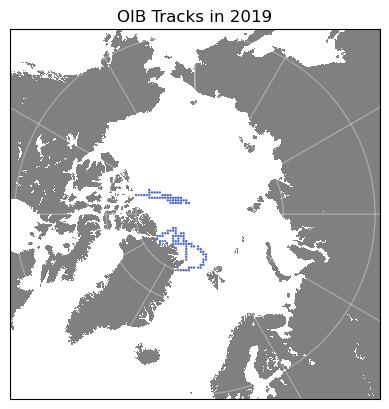

In [ ]:
plt.figure()
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
plt.title('OIB Tracks in 2019')
m.scatter(lon_data, lat_data, latlon=True, alpha=1, s=0.5, c=OIB_snow, cmap="coolwarm", vmin=0, vmax=6)
plt.show()

year = '04-2019'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/OIB_tracks' + year + '.png')



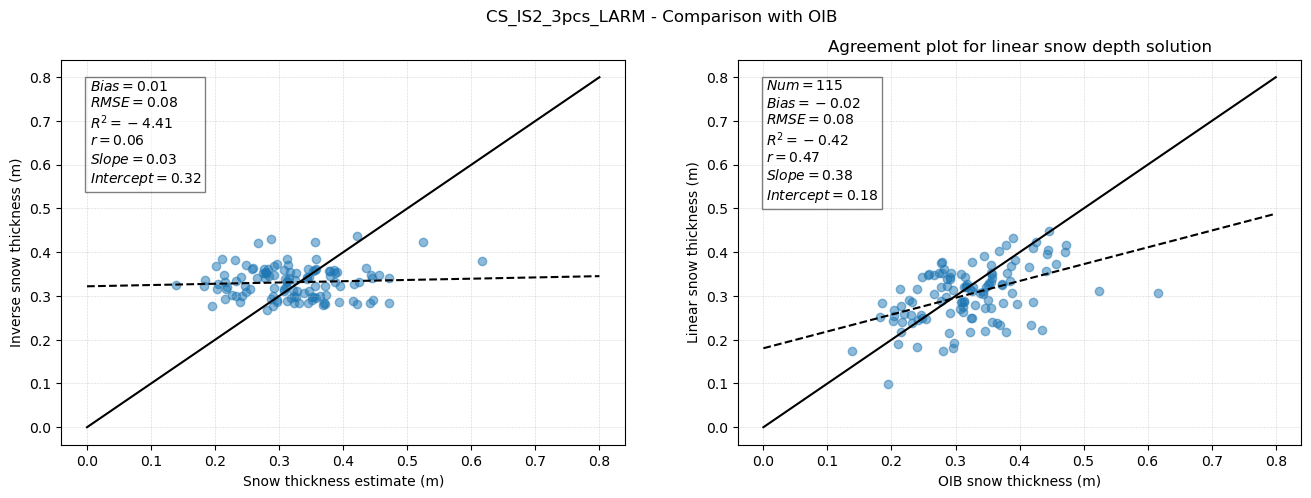

In [ ]:
fig = plt.figure(figsize = (16, 5))
plt.suptitle('CS_IS2_3pcs_LARM - Comparison with OIB')

ax = fig.add_subplot(121)
plt.scatter(OIB_snow, snow_data, alpha = 0.5)
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('Snow thickness estimate (m)')
plt.ylabel('Inverse snow thickness (m)')
#ax.set_title("Agreement plot for inverse snow model")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_data, OIB_snow)
r_snow = pearson(OIB_snow, snow_data)

textstr = '\n'.join((
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')


ax = fig.add_subplot(122)
data = np.array(Hs_data)
md, rmse, r2, slope, intercept = analyse(data, OIB_snow)
r_snow_linear = pearson(OIB_snow, Hs_data)

plt.scatter(OIB_snow, Hs_data, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.xlabel('OIB snow thickness (m)')
plt.ylabel('Linear snow thickness (m)')

textstr = '\n'.join((
    rf'$Num = {len(Hs_data)}$',
    rf'$Bias={md:.2f}$',
    rf'$RMSE={rmse:.2f}$',
    rf'$R^2={r2:.2f}$',
    rf'$r = {r_snow_linear:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)
# Plot linear regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')
ax.set_title("Agreement plot for linear snow depth solution")


if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/validation_OIB' + year + '.png')




In [ ]:
snow_file = nc.Dataset("/home/erb/masterproject/MSCI_project/validation_data/various_data/SMLG_snod_EASE.nc")
snow_11 = snow_file.variables['Snow Depth'][3607, :, :]
snow_12 = snow_file.variables['Snow Depth'][3636, :, :]
snow_01 = snow_file.variables['Snow Depth'][3667, :, :]
snow_02 = snow_file.variables['Snow Depth'][3697, :, :]
snow_03 = snow_file.variables['Snow Depth'][3727, :, :]
snow_file.close()
snow_lg = [snow_11,snow_12,snow_01,snow_02,snow_03]


In [ ]:
is_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200315.npy"]

cs_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200315.npy",]

inverse_snow_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20191115_inputtypePeerIndices_priorOldPrior_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20191215_inputtypePeerIndices_priorOldPrior_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20200115_inputtypePeerIndices_priorOldPrior_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20200215_inputtypePeerIndices_priorOldPrior_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20200315_inputtypePeerIndices_priorOldPrior_snow.npy',]

# grids
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

In [ ]:
snow_inverse =[]
snow_linear = []
snow_compare = []

DENSITY_WATER = 997.0
DENSITY_ICE = 917.0
DENSITY_SNOW = 300.0
SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW = 1.28

for i in range(5):
    
    A = (DENSITY_WATER - DENSITY_ICE) / DENSITY_WATER
    B = 1 - SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW -DENSITY_SNOW/DENSITY_WATER
    D = 1 - DENSITY_SNOW/DENSITY_WATER

    Hi = (A*np.load(cs_files[i]) - B*np.load(is_files[i]))/ A*(D-B)
    Hs = (np.load(cs_files[i]) - np.load(is_files[i])) / (B -D)

    snow_inverse_data = np.load(inverse_snow_files[i])
    snow_inverse_data = mask_observations(Hi,snow_inverse_data)

    for k in range(360):
        for j in range(360):
            if not (snow_lg[i].mask[k][j]) and not np.isnan(snow_inverse_data[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                snow_compare.append(snow_lg[i].data[k][j])
                snow_linear.append(Hs[k][j])

Error in callback <function _draw_all_if_interactive at 0x7f61a4563790> (for post_execute):


KeyboardInterrupt: 

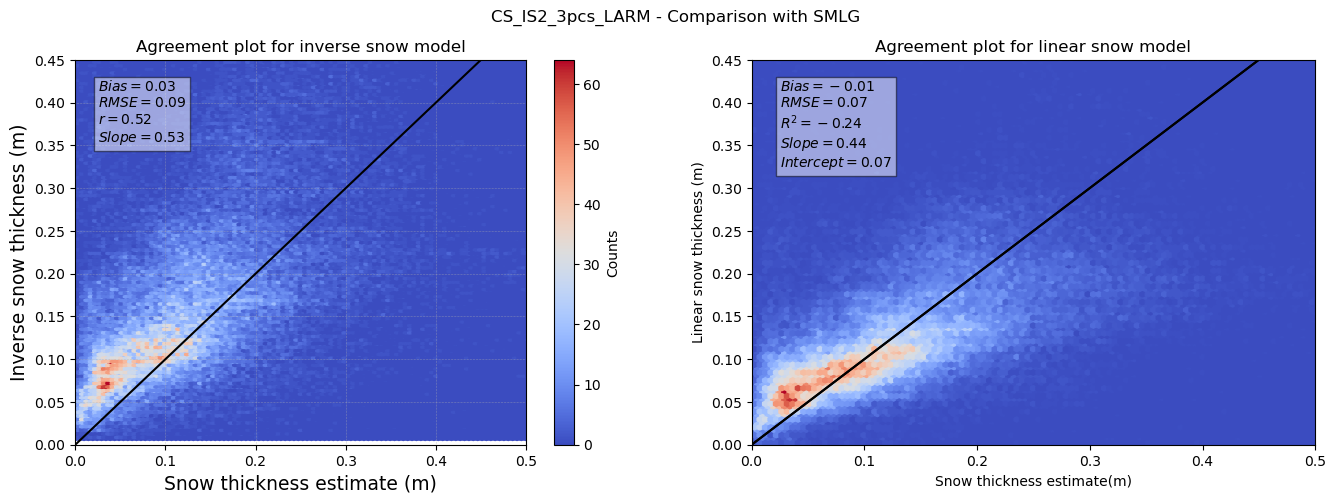

In [ ]:
fig = plt.figure(figsize=(16, 5))
plt.suptitle('CS_IS2_3pcs_LARM - Comparison with SMLG')
ax = fig.add_subplot(121)
#plt.scatter(snow_compare, snow_inverse, alpha = 0.5)
plt.hexbin(snow_compare, snow_inverse, gridsize=200, cmap='coolwarm')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.ylim(0, 0.45)
plt.xlim(0, 0.5)
plt.colorbar(label='Counts')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('Snow thickness estimate (m)', fontsize = 13.5)
plt.ylabel('Inverse snow thickness (m)', fontsize = 13.5)
ax.set_title("Agreement plot for inverse snow model")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_inverse, snow_compare)
r_snow = pearson(snow_compare, snow_inverse)

textstr = '\n'.join((
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$'
    #rf'$Intercept = {intercept:.2f}$'
    ))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
#x_values = np.array([0,0.8])
#y_values = slope * x_values + intercept
#plt.plot(x_values, y_values, 'k--', label='Linear Regression')




ax = fig.add_subplot(122)
#plt.scatter(snow_compare, snow_linear, alpha = 0.5)
hb = ax.hexbin(snow_compare, snow_linear, gridsize=200, cmap='coolwarm')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.ylim(0, 0.45)
plt.xlim(0, 0.5)
plt.plot([0,0.8] , [0,0.8], 'k-')
#plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('Snow thickness estimate(m)')
plt.ylabel('Linear snow thickness (m)')

md_snow_linear, rmse_snow_linear, r2_snow_linear, slope, intercept = analyse(snow_linear, snow_compare)

textstr = '\n'.join((
    rf'$Bias={md_snow_linear:.2f}$',
    rf'$RMSE={rmse_snow_linear:.2f}$',
    rf'$R^2={r2_snow_linear:.2f}$',
    #rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)
ax.set_title("Agreement plot for linear snow model")


year = '2019-2020'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/validation_SMLG' + year + '.png')



## Validation for ice 

In [ ]:
filename = '/home/hds/DATA/AWI_SIT/SMOS_daily/2019/11/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20191109_20191115_r_v202_02_l4sit.nc'
AWISMOS = nc.Dataset(filename)



In [ ]:
lon_AWISMOS = AWISMOS.variables['lon']
lat_AWISMOS = AWISMOS.variables['lat']
SIT_AWISMOS = AWISMOS.variables['analysis_sea_ice_thickness']


In [ ]:
SIT_AWISMOS2 = SIT_AWISMOS[0][36:396,36:396][::-1, :]

In [ ]:
is_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191115.npy"]
cs_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191115.npy"]

inverse_ice_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20191115_inputtypePeerIndices_priorOldPrior_ice.npy']

# grids
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

In [ ]:
ice_inverse =[]
ice_linear = []
ice_compare = []

DENSITY_WATER = 997.0
DENSITY_ICE = 917.0
DENSITY_SNOW = 300.0
SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW = 1.28

A = (DENSITY_WATER - DENSITY_ICE) / DENSITY_WATER
B = 1 - SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW -DENSITY_SNOW/DENSITY_WATER
D = 1 - DENSITY_SNOW/DENSITY_WATER

Hi = (A*np.load(cs_files[0]) - B*np.load(is_files[0]))/ A*(D-B)

ice_inverse_data = np.load(inverse_ice_files[0])
ice_inverse_data = mask_observations(Hi,ice_inverse_data)


for k in range(360):
    for j in range(360):
        if not SIT_AWISMOS2.mask[k][j] and not np.isnan(ice_inverse_data[k][j]):
            ice_inverse.append(ice_inverse_data[k][j])
            ice_compare.append(SIT_AWISMOS2[k][j])
            ice_linear.append(Hi[k][j])


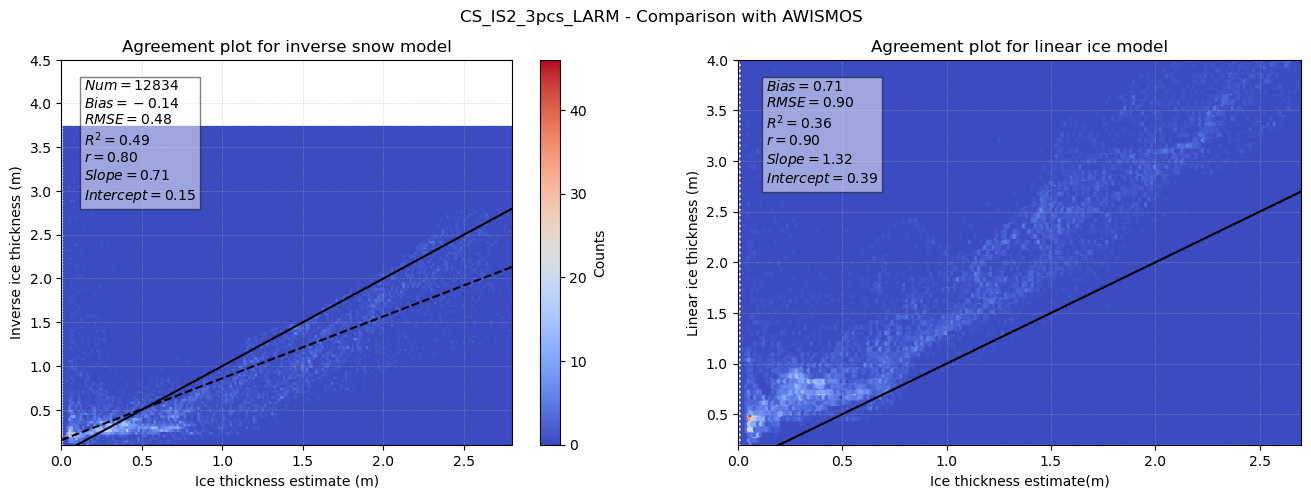

In [ ]:
fig = plt.figure(figsize=(16, 5))

plt.suptitle('CS_IS2_3pcs_LARM - Comparison with AWISMOS')

ax = fig.add_subplot(121)
#plt.scatter(ice_compare, ice_inverse, alpha = 0.5)
plt.hexbin(ice_compare, ice_inverse, gridsize=200, cmap='coolwarm')
plt.plot([0,5] , [0,5], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlim(0, 2.8)
plt.ylim(0.1, 4.5)
plt.colorbar(label='Counts')
plt.xlabel('Ice thickness estimate (m)')
plt.ylabel('Inverse ice thickness (m)')
ax.set_title("Agreement plot for inverse snow model")

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse, ice_compare)
r_ice = pearson(ice_compare, ice_inverse)

textstr = '\n'.join((
    rf'$Num = {len(ice_compare)}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    rf'$R^2={r2_ice_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line
x_values = np.array([0,7])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')


ax = fig.add_subplot(122)
#plt.scatter(snow_compare, snow_linear, alpha = 0.5)
hb = ax.hexbin(ice_compare, ice_linear, gridsize=200, cmap='coolwarm')
plt.plot([0,5] , [0,5], 'k-')
plt.ylim(0.2, 4)
plt.xlim(0, 2.7)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('Ice thickness estimate(m)')
plt.ylabel('Linear ice thickness (m)')

md_ice_linear, rmse_ice_linear, r2_ice_linear, slope, intercept = analyse(ice_linear, ice_compare)
r_ice = pearson(ice_compare, ice_linear)


textstr = '\n'.join((
    rf'$Bias={md_ice_linear:.2f}$',
    rf'$RMSE={rmse_ice_linear:.2f}$',
    rf'$R^2={r2_ice_linear:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)
ax.set_title("Agreement plot for linear ice model")


date = '11/2019'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/validation_AWISMOS' + year + '.png')


## Validation map

In [ ]:

laku_files = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201811_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201812_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201901_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201902_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201903_EASE2_laku_UIT.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_map/snow_201904_EASE2_laku_UIT.npy"]

laku_UIT = []

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

for i in range(len(laku_files)):
    laku_UIT.append(np.load(laku_files[i]))

KeyboardInterrupt: 

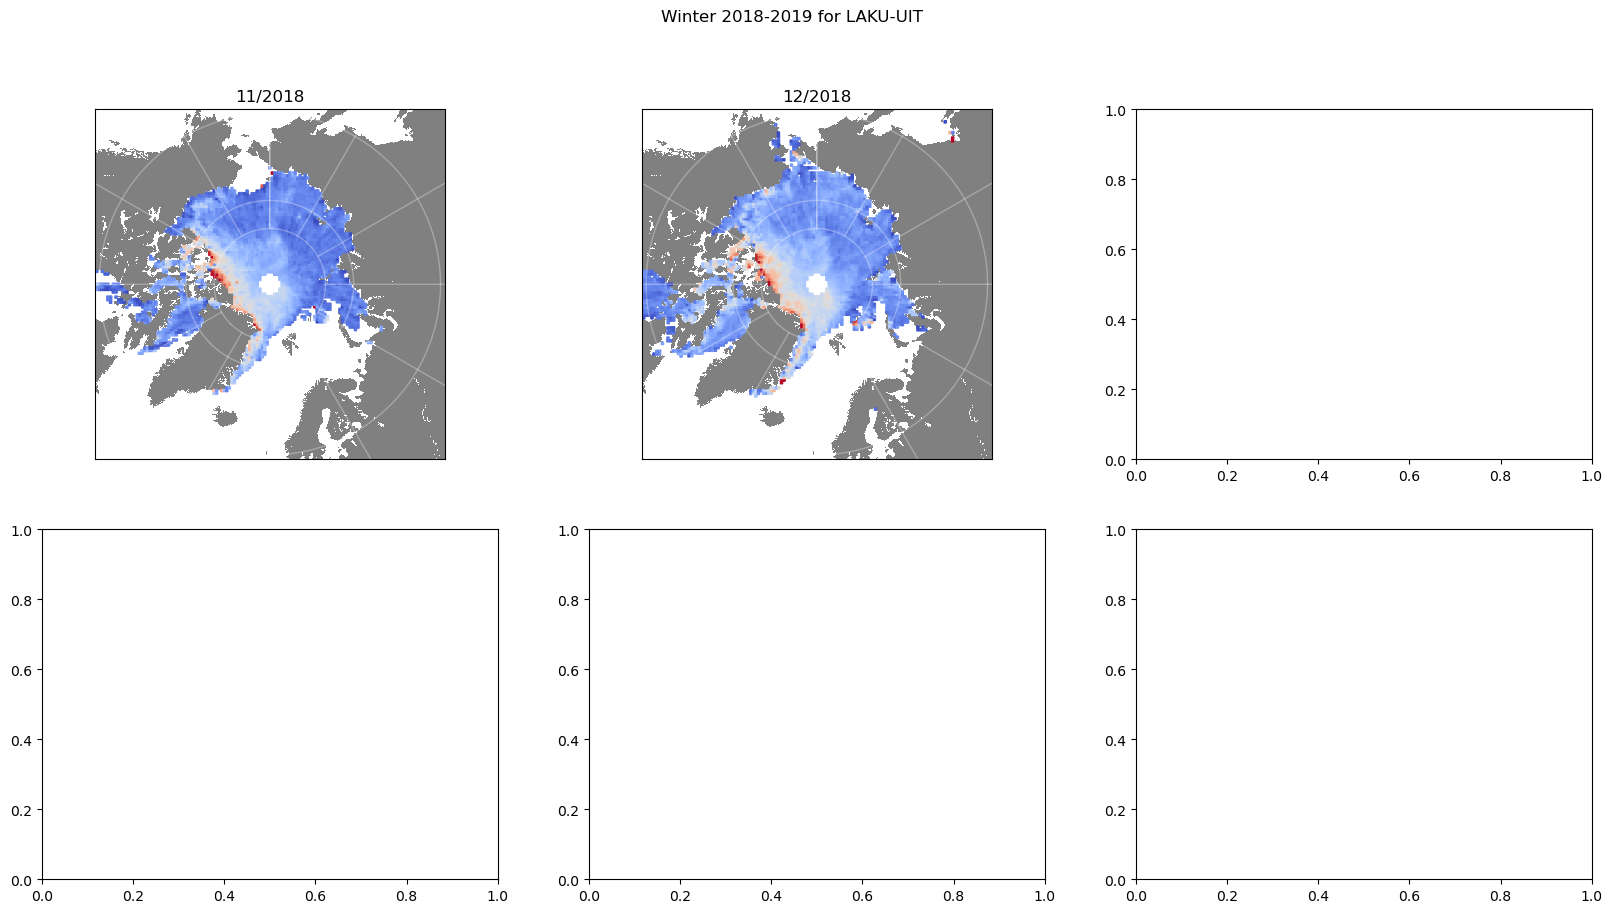

In [ ]:
date = ['11/2018', '12/2018', '01/2019', '02/2019', '03/2019', '04/2019']

fig, axes = plt.subplots(2, 3, figsize=(20, 10))


plt.suptitle('Winter 2018-2019 for LAKU-UIT')

vmin = 0
vmax = 0.5

for i, ax in enumerate(axes.flat):
    m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7, ax=ax)
    draw_map(m)
    ax.set_title(date[i])
    sc = m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=laku_UIT[i], 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)

cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Snow Depth')



if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/map_LAKU_UIT_2018-2019' + '.png')


In [ ]:
inverse_snow_files = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20181115_inputtypePeerIndices_priorOldPrior_snow.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20181215_inputtypePeerIndices_priorOldPrior_snow.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20190115_inputtypePeerIndices_priorOldPrior_snow.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20190215_inputtypePeerIndices_priorOldPrior_snow.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20190315_inputtypePeerIndices_priorOldPrior_snow.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20190415_inputtypePeerIndices_priorOldPrior_snow.npy"]

inverse_ice_files = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20181115_inputtypePeerIndices_priorOldPrior_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20181215_inputtypePeerIndices_priorOldPrior_ice.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20190115_inputtypePeerIndices_priorOldPrior_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20190215_inputtypePeerIndices_priorOldPrior_ice.npy",
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20190315_inputtypePeerIndices_priorOldPrior_ice.npy", 
                 "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationDelaunay_initcell1000_iteration700000_date20190415_inputtypePeerIndices_priorOldPrior_ice.npy"]


inverse_map_snow = []
inverse_map_ice = []

for i in range(len(inverse_snow_files)):
    inverse_map_snow.append(np.load(inverse_snow_files[i]))
    inverse_map_ice.append(np.load(inverse_ice_files[i]))


In [ ]:
np.load(inverse_ice_files[0])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

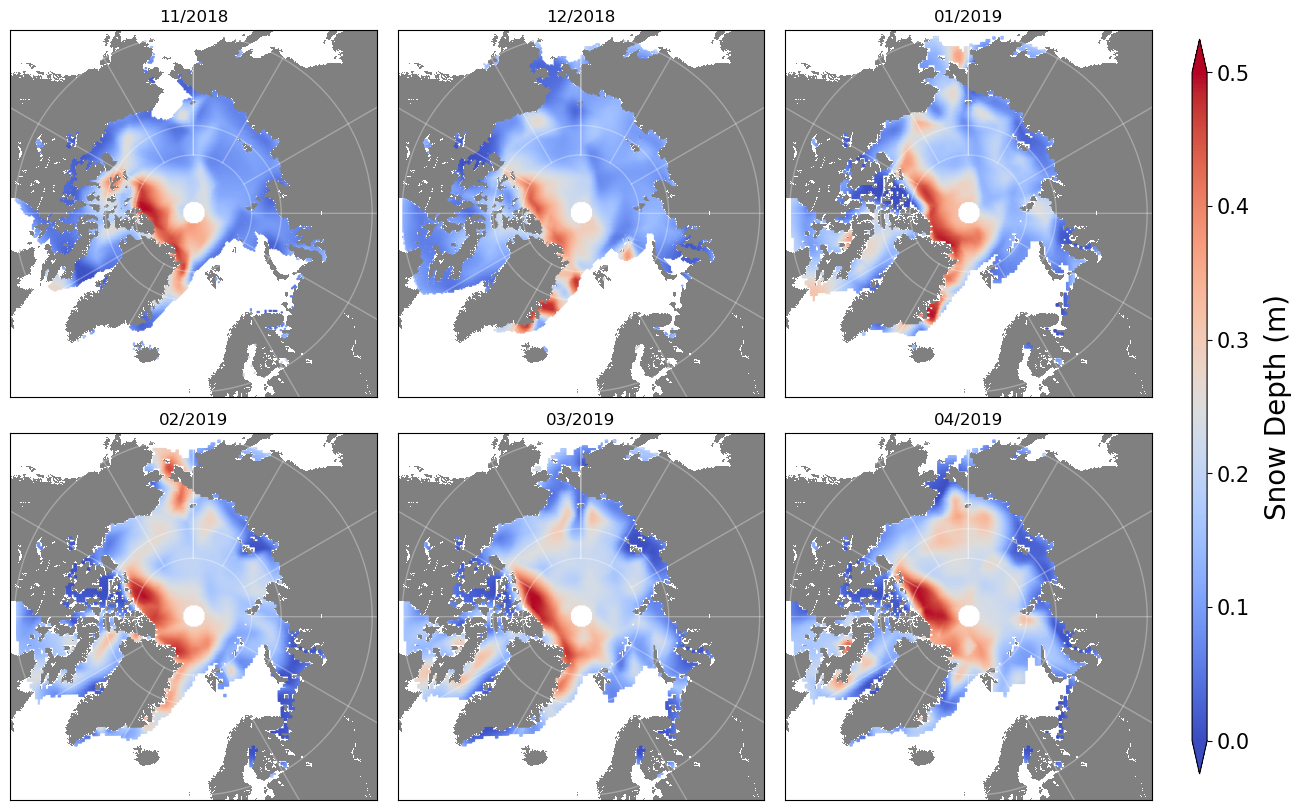

In [ ]:
import matplotlib.gridspec as gridspec

date = ['11/2018', '12/2018', '01/2019', '02/2019', '03/2019', '04/2019']

fig = plt.figure(figsize=(15, 10))
spec = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.1, wspace=0)

vmin = 0
vmax = 0.5

for i, ax in enumerate(spec):
    ax = plt.subplot(spec[i])
    m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7, ax=ax)
    draw_map(m)

    sc = m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=inverse_map_snow[i], 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)
    ax.set_title(date[i])


cbar_ax = fig.add_axes([0.92, 0.136, 0.01, 0.735])
cbar = fig.colorbar(sc, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Snow Depth (m)", fontsize=20, labelpad=10)


if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/map_inverse_snow_2018-2019' + '.png')

plt.show()


KeyboardInterrupt: 

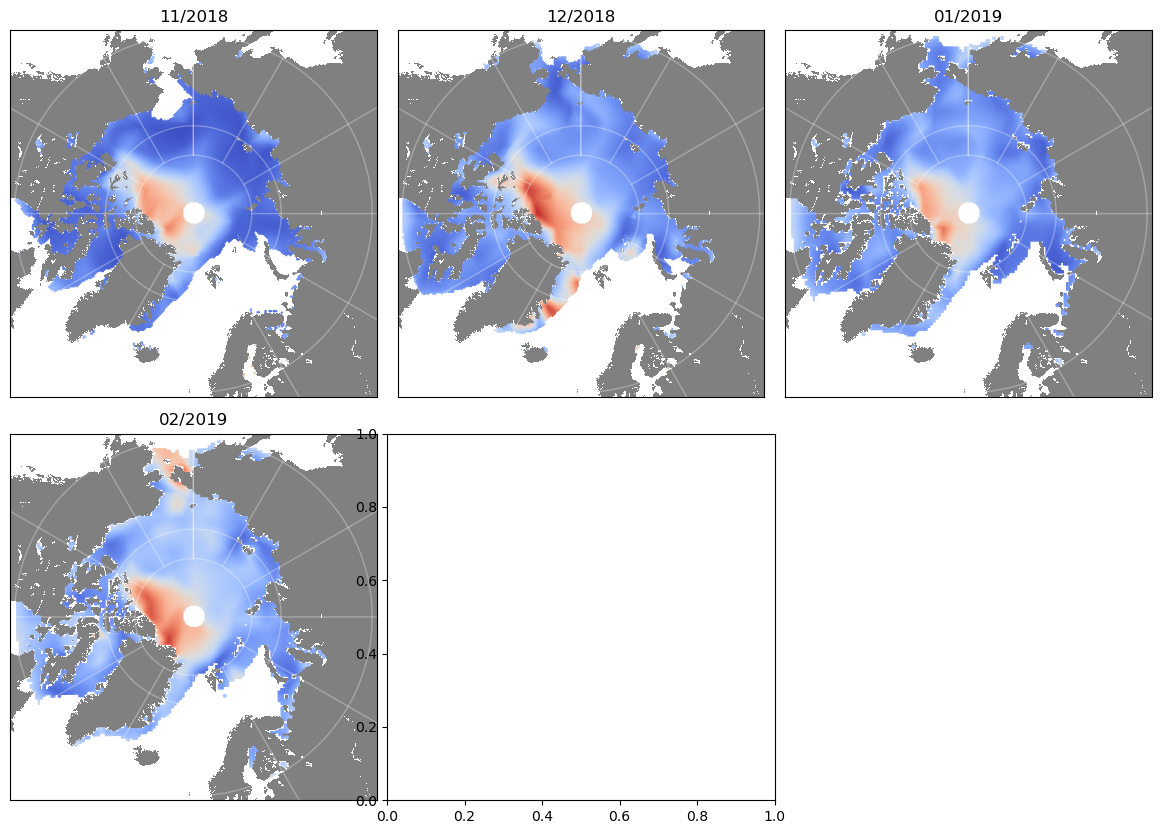

In [ ]:
import matplotlib.gridspec as gridspec

date = ['11/2018', '12/2018', '01/2019', '02/2019', '03/2019', '04/2019']

fig = plt.figure(figsize=(15, 10))
spec = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.1, wspace=0)

vmin = 0
vmax = 5

for i, ax in enumerate(spec):
    ax = plt.subplot(spec[i])
    m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7, ax=ax)
    draw_map(m)

    sc = m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=inverse_map_ice[i], 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)
    ax.set_title(date[i])


cbar_ax = fig.add_axes([0.92, 0.136, 0.01, 0.735])
cbar = fig.colorbar(sc, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Ice thickness (m)", fontsize=20, labelpad=10)


if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/map_inverse_ice_2018-2019' + '.png')

plt.show()


NameError: name 'inverse_map' is not defined

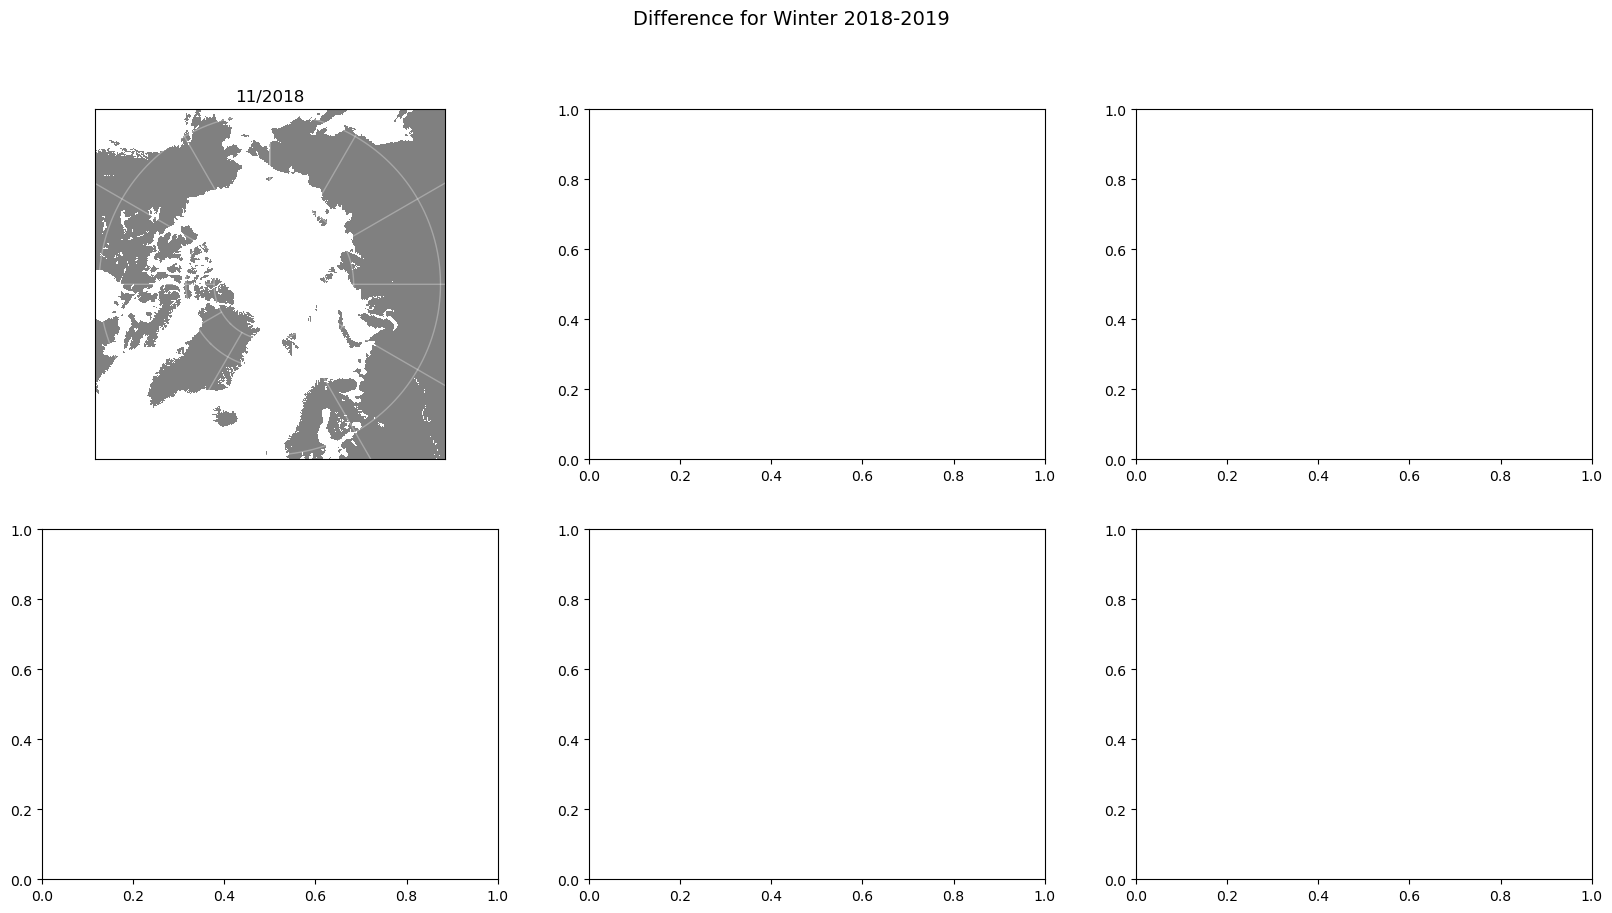

In [ ]:
date = ['11/2018', '12/2018', '01/2019', '02/2019', '03/2019', '04/2019']

fig, axes = plt.subplots(2, 3, figsize=(20, 10))


plt.suptitle('Difference for Winter 2018-2019', fontsize=14)

vmin = -0.5
vmax = 0.5

for i, ax in enumerate(axes.flat):
    m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7, ax=ax)
    draw_map(m)
    ax.set_title(date[i])
    sc = m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=inverse_map[i] - laku_UIT[i], 
                   cmap="viridis", vmin=vmin, vmax=vmax)

cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Snow Difference')


In [ ]:
path_ice_2p = "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/tesselationVoronoi_initcell1000_iteration700000_date20190415_inputtypePeerIndices_densityVariousDensity_ice.npy"
path_snow_2p = "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/tesselationVoronoi_initcell1000_iteration700000_date20190415_inputtypePeerIndices_densityVariousDensity_snow.npy"

In [ ]:
path_ice_3p = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationVoronoi_initcell1000_iteration700000_date20190415_inputtypeAllIndices_ice.npy'
path_snow_3p = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/tesselationVoronoi_initcell1000_iteration700000_date20190415_inputtypeAllIndices_snow.npy'

In [ ]:
ice_2p = np.load(path_ice_2p)
snow_2p = np.load(path_snow_2p)

ice_3p = np.load(path_ice_3p)
snow_3p = np.load(path_snow_3p)

In [ ]:
ice_difference = ice_2p - ice_3p
snow_difference = snow_2p - snow_3p

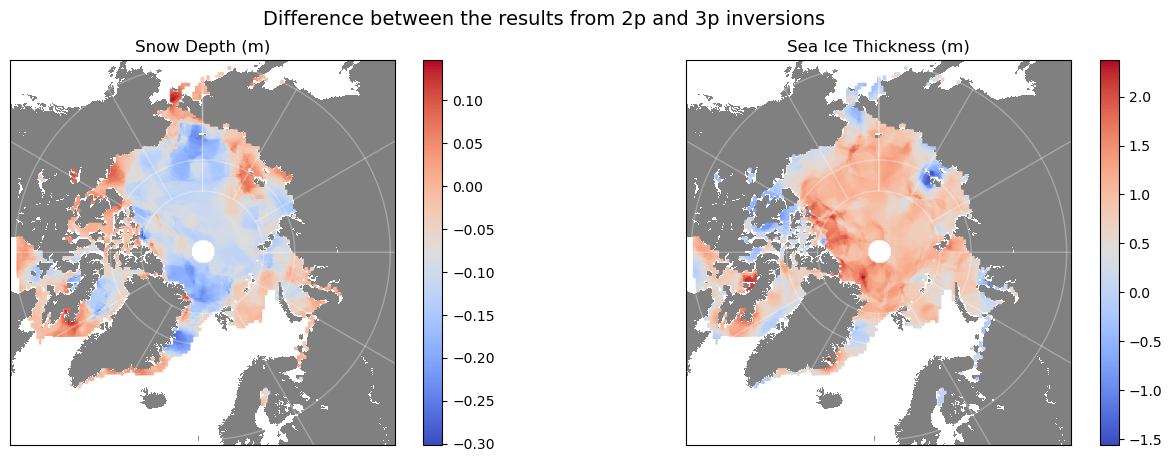

In [ ]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)

fig.suptitle("Difference between the results from 2p and 3p inversions", fontsize=14)

m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
plt.title('Snow Depth (m)')
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=snow_difference, cmap="coolwarm")#, vmin=-0.5, vmax=0.5)
plt.colorbar()

ax = fig.add_subplot(122)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
plt.title('Sea Ice Thickness (m)')
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=ice_difference, cmap="coolwarm")#, vmin=-2, vmax=2)
plt.colorbar()


## Penetration factor

In [ ]:
penetration_cs2_prior_1 = []
penetration_cs2_prior_2 = []

penetration_1 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_proposal0.1_window+-2j_prioruniform-0.2-1.5_error0.01_penetration.npy')
penetration_2 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_proposal0.1_window+-2j_prioruniform-0.5-0.8_error0.01_penetration.npy')

for i in range(360):
    for j in range(360):
        penetration_cs2_prior_1.append(penetration_1[i][j])
        penetration_cs2_prior_2.append(penetration_2[i][j])


Text(0, 0.5, 'Counts')

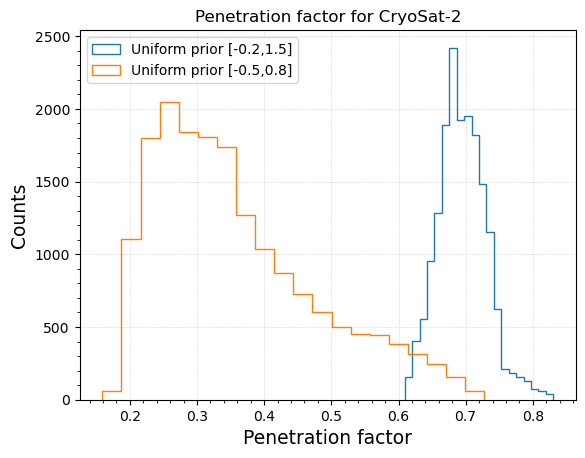

In [ ]:
fig, ax = plt.subplots()
ax.hist(penetration_cs2_prior_1, histtype='step', bins = 20, stacked=True, fill = False, label = "Uniform prior [-0.2,1.5]")
ax.hist(penetration_cs2_prior_2, histtype='step', bins = 20, stacked=True, fill = False, label = "Uniform prior [-0.5,0.8]")
ax.grid(linestyle='dotted', linewidth ='0.4')
ax.minorticks_on()
ax.legend()
plt.title('Penetration factor for CryoSat-2')
plt.xlabel('Penetration factor', fontsize = 13.5)
plt.ylabel('Counts', fontsize = 13.5)

#plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/hist_cs2_20190415.png')

In [ ]:
penetration_is2_prior_1, penetration_is2_prior_2 = [], []

penetration_2 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_proposal0.1_window+-2j_prioruniform-0.5-0.8_error0.01_alphais2_penetration.npy')
penetration_1 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_proposal0.1_window+-2j_prioruniform-0.2-1.5_error0.01_alphais2_penetration.npy')

for i in range(360):
    for j in range(360):
        penetration_is2_prior_1.append(penetration_1[i][j])
        penetration_is2_prior_2.append(penetration_2[i][j])


Text(0, 0.5, 'Counts')

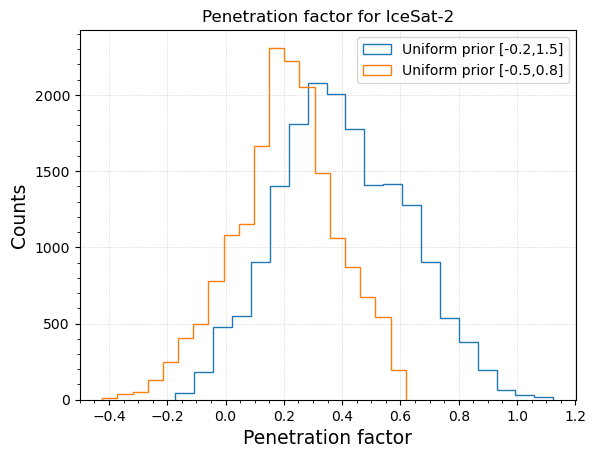

In [ ]:
fig, ax = plt.subplots()
ax.hist(penetration_is2_prior_1, histtype='step', bins = 20, stacked=True, fill = False, label = "Uniform prior [-0.2,1.5]")
ax.hist(penetration_is2_prior_2, histtype='step', bins = 20, stacked=True, fill = False, label = "Uniform prior [-0.5,0.8]")
ax.grid(linestyle='dotted', linewidth ='0.4')
ax.minorticks_on()
ax.legend()
plt.title('Penetration factor for IceSat-2')
plt.xlabel('Penetration factor', fontsize = 13.5)
plt.ylabel('Counts', fontsize = 13.5)


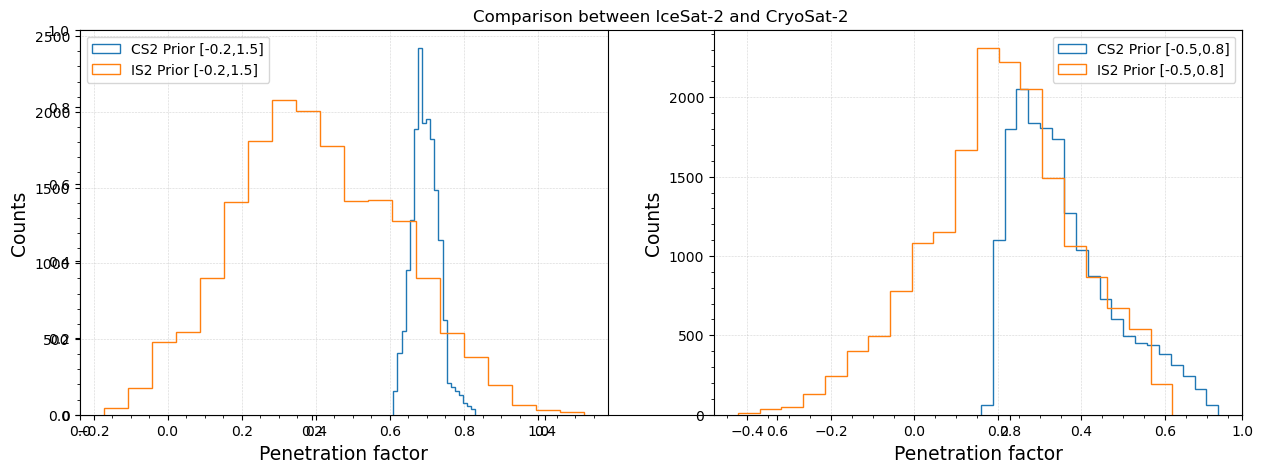

In [ ]:
fig = plt.figure(figsize = (15, 5))

plt.title('Comparison between IceSat-2 and CryoSat-2')


ax = fig.add_subplot(121)
ax.hist(penetration_cs2_prior_1, histtype='step', bins = 20, stacked=True, fill = False, label = "CS2 Prior [-0.2,1.5]")
ax.hist(penetration_is2_prior_1, histtype='step', bins = 20, stacked=True, fill = False, label = "IS2 Prior [-0.2,1.5]")
ax.grid(linestyle='dotted', linewidth ='0.4')
ax.minorticks_on()
ax.legend()
ax.set_xlabel('Penetration factor', fontsize = 13.5)
ax.set_ylabel('Counts', fontsize = 13.5)


ax = fig.add_subplot(122)
ax.hist(penetration_cs2_prior_2, histtype='step', bins = 20, stacked=True, fill = False, label = "CS2 Prior [-0.5,0.8]")
ax.hist(penetration_is2_prior_2, histtype='step', bins = 20, stacked=True, fill = False, label = "IS2 Prior [-0.5,0.8]")
ax.grid(linestyle='dotted', linewidth ='0.4')
ax.minorticks_on()
ax.legend()
ax.set_xlabel('Penetration factor', fontsize = 13.5)
ax.set_ylabel('Counts', fontsize = 13.5)

plt.show()


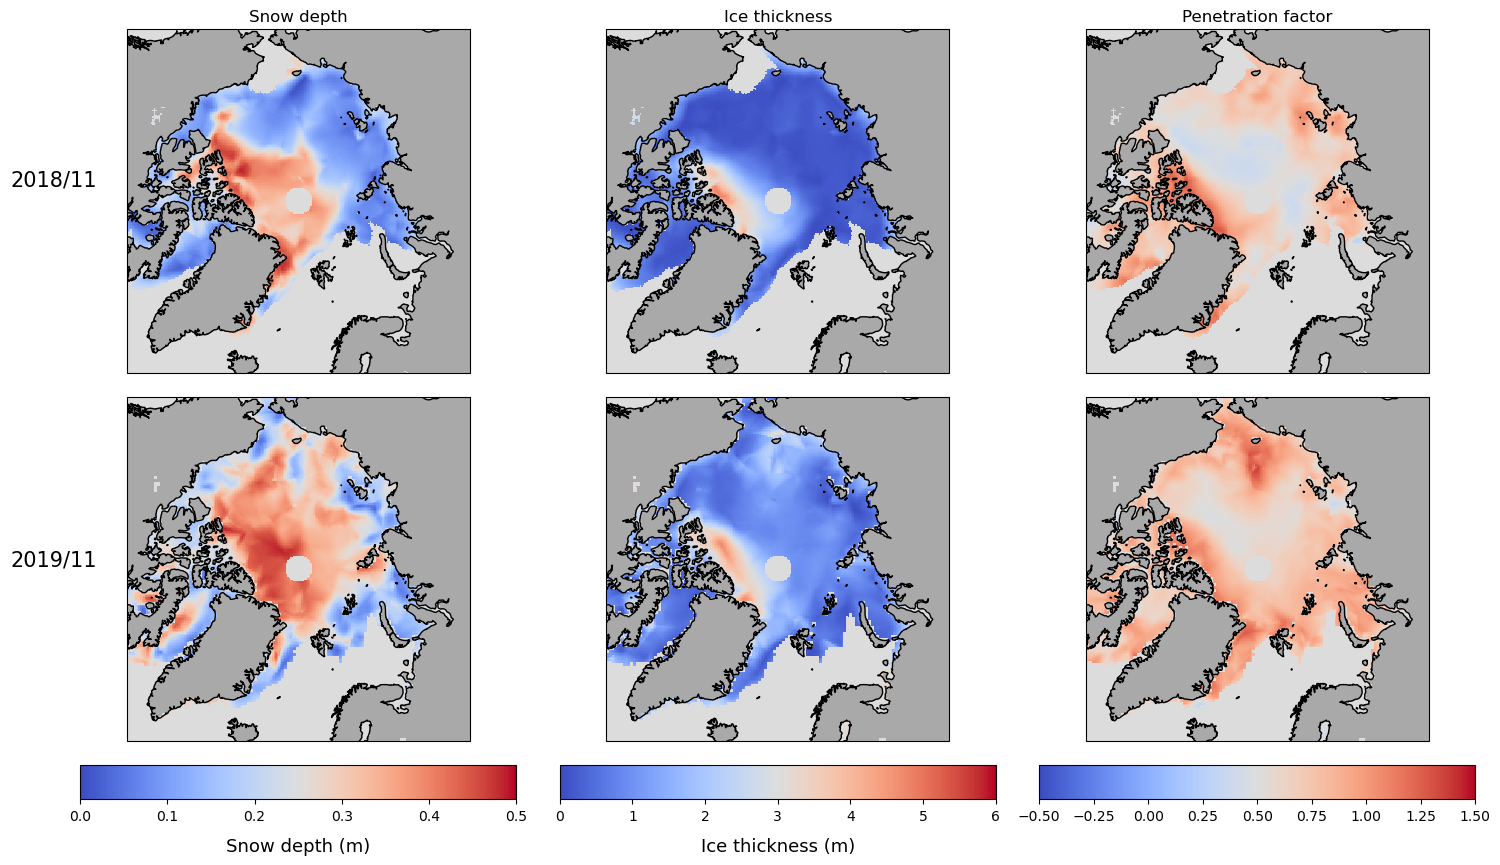

In [27]:
# change these according to date
snow_april = np.load("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/201904/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_proposal0.8_window15j_prioruniform-0.5-1.5_densitymixte_alphacs2_hierarchicalno_snow.npy")
ice_april = np.load("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/201904/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_proposal0.8_window15j_prioruniform-0.5-1.5_densitymixte_alphacs2_hierarchicalno_ice.npy")
cs_april = np.load("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/201904/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_proposal0.8_window15j_prioruniform-0.5-1.5_densitymixte_alphacs2_hierarchicalno_penetration.npy")

snow_nov = np.load("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/201811/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_proposal0.8_window15j_prioruniform-0.5-1.5_densitymixte_alphacs2_hierarchicalno_snow.npy")
ice_nov = np.load("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/201811/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_proposal0.8_window15j_prioruniform-0.5-1.5_densitymixte_alphacs2_hierarchicalno_ice.npy")
cs_nov = np.load("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/results_npy/non_interpolated_input/201811/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_proposal0.8_window15j_prioruniform-0.5-1.5_densitymixte_alphacs2_hierarchicalno_penetration.npy")



lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


fig = plt.figure(figsize = (18,10))
spec = gridspec.GridSpec(ncols=3, nrows=3,wspace=0.1,hspace=0.1,height_ratios= [1, 1, 0.1])

ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, snow_nov,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)
plt.title('Snow depth')
#a = fig.colorbar(p_map,shrink=0.5, pad=0.05)
#a.ax.tick_params(labelsize=12)
#a.set_label('m',fontsize=15)


ax2 = fig.add_subplot(spec[1],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, ice_nov,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
plt.title("Ice thickness")
#a = fig.colorbar(p_map, shrink=0.5, pad=0.05)
#a.ax.tick_params(labelsize=12)
#a.set_label('m',fontsize=15)

ax2 = fig.add_subplot(spec[2],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, cs_nov,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = -0.5, vmax = 1.5)
plt.title("Penetration factor")
#a = fig.colorbar(p_map, shrink=0.5, pad=0.05)
#a.ax.tick_params(labelsize=12)


ax1 = fig.add_subplot(spec[3], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map_snow = ax1.pcolormesh(lon_g,lat_g, snow_april,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)
#plt.title('Snow depth')
#a = fig.colorbar(p_map,shrink=0.5, pad=0.05)
#a.ax.tick_params(labelsize=12)
#a.set_label('m',fontsize=15)


ax2 = fig.add_subplot(spec[4],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map_ice = ax2.pcolormesh(lon_g,lat_g, ice_april,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
#plt.title("Ice thickness")
#a = fig.colorbar(p_map, shrink=0.5, pad=0.05)
#a.ax.tick_params(labelsize=12)
#a.set_label('m',fontsize=15)

ax2 = fig.add_subplot(spec[5],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map_penetration = ax2.pcolormesh(lon_g,lat_g, cs_april,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = -0.5, vmax = 1.5)
#plt.title("Penetration factor")
#a = fig.colorbar(p_map, shrink=0.5, pad=0.05)
#a.ax.tick_params(labelsize=12)


cax = fig.add_subplot(spec[6])
fig.colorbar(p_map_snow, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Snow depth (m)', labelpad = 10, fontsize = 13)
cax.xaxis.set_label_position('bottom')

cax = fig.add_subplot(spec[7])
fig.colorbar(p_map_ice, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Ice thickness (m)', labelpad = 10, fontsize = 13)
cax.xaxis.set_label_position('bottom')


cax = fig.add_subplot(spec[8])
fig.colorbar(p_map_penetration, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_position('bottom')



date = ["2018/11", "2019/11"]

fig.text(0.11, 0.73, date[0], va='center', ha='center', fontsize=15)
fig.text(0.11, 0.35, date[1], va='center', ha='center', fontsize=15)

save_fig = 0


if save_fig == 1:
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS2_3pcs_LARM/validation/201904.png', dpi = 300)




plt.show()